In [1]:
using DifferentialEquations, Plots, Test, BenchmarkTools, LinearAlgebra, SparseArrays, DiffEqOperators
using Perla1

┌ Info: Recompiling stale cache file C:\Users\Chiyoung Ahn\.julia\compiled\v1.0\Perla1\nyjg2.ji for Perla1 [c0b4307c-ed70-5091-a49a-e521e9681a02]
└ @ Base loading.jl:1184


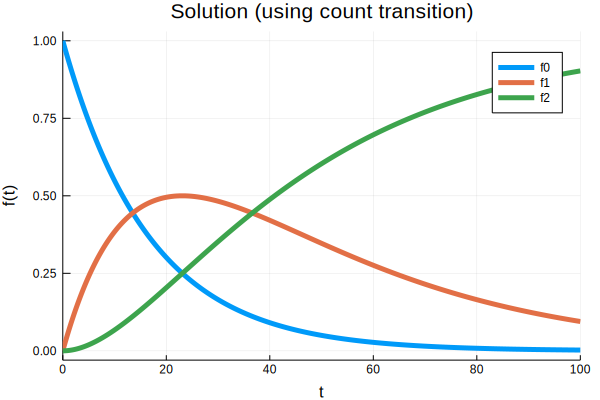

In [2]:
# simple duopoly
N = 2
T = 100.0
μ = 0.0
θ = 0.06 # baseline parameter from Perla16 (Appendix E.4)
θ_d = 0.0 # assume constant θ_d (for Krylov methods)
f0 = 0.5 # assume constant f0 (for Krylov methods)
# θ_d = 0.21 # baseline parameter from Perla16 (Appendix E.4)


# define generator
Q_a = get_Q(N, μ, θ, θ_d)
Q(a) = Q_a(a)

# solve the corresponding ODE
f_0 = [1.0; 0.0; 0.0]
sol_count = solve_transition_dynamics(Q, f_0, T)

# convert to the counting solution
f0_count(a) = sol_count(a)[1]
f1_count(a) = sol_count(a)[2]
f2_count(a) = sol_count(a)[3]

# plot
plot(sol_count,linewidth=5,
    title="Solution (using count transition)",
    xaxis="t",yaxis="f(t)",label=["f0" "f1" "f2"])

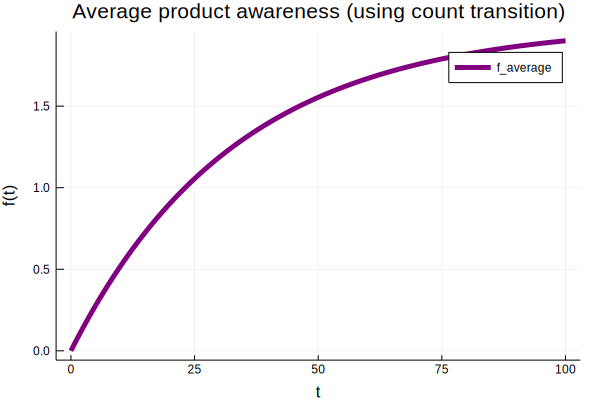

In [3]:
f_count(a) = dot(0:N, sol_count(a)) # average product awareness
plot(0:0.01:T, f_count,linewidth=5,
    title="Average product awareness (using count transition)",
    xaxis="t",yaxis="f(t)",label=["f_average"],linecolor="purple")

# Using Krylov method

In [4]:
# some setups
using ExponentialUtilities

function get_Q_base(N, μ, θ)
    # construct (N+1) by (N+1) base matrix such that
    # the last N rows of base_matrix correspond to the last N rows of Q(a) 
    # based on (A.3) in appendix
    dl = fill(μ, N)
    d = collect(-μ.-(N:-1:0).*(θ/N))
    du = collect((N:-1:1).*(θ/N))
    return dl, d, du
end

struct AwarenessModel
    N # number of products
    f0 # time-invariant f0
    dl # lower diagonal elements of Q
    d # diagonal elements of Q
    du # upper diagonal elements of Q
    function AwarenessModel(N, μ, θ, f0)
        dl, d, du = get_Q_base(N, μ, θ)
        new(N, f0, dl, d, du)
    end
end

In [5]:
# overload size, ishermitian, mul! from LinearAlgebra to use expv
LinearAlgebra.size(Q::AwarenessModel, i::Int64) = N+1
LinearAlgebra.ishermitian(Q::AwarenessModel) = false

function LinearAlgebra.mul!(y, Q::AwarenessModel, b)
    # note that the operator is transposed
    N = length(y)-1
    y[1] = -(θ + θ_d*(1-Q.f0))*b[1]+Q.dl[1]*b[2]
    for i in 2:N
        y[i] = Q.du[i]*b[i-1] + Q.d[i]*b[i] + Q.dl[i]*b[i+1]
    end
    y[2] = (θ + θ_d*(1-Q.f0))*b[1]+Q.d[2]*b[2]+Q.dl[2]*b[3]
    y[end] = Q.du[end]*b[N] + Q.d[end]*b[N+1]
end

function LinearAlgebra.opnorm(Q::AwarenessModel, p)
    # NOTE: ASSUMES μ,θ > 0 AND p = Inf
    # TODO: add unit tests accordingly
    # Inf norm of Q' is equivalent to the max_i (sum of ith row in abs vals) of Q'
    # Except the very first two rows, this is zero for every row; see (A.3) in appendix 
    # Hence, sufficient to consider max of the first two rows
    # [[-(θ + θ_d*(1-f0)) μ];
    # [(θ + θ_d*(1-f0)) -μ-(N-1)*θ/N]]
    ii = abs(θ + θ_d*(1-f0))
    return (max(ii + μ, ii + μ + (N-1)*θ/N))
end

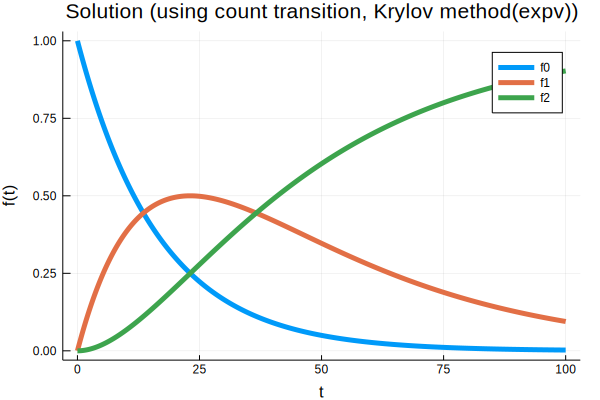

In [6]:
# generate an AwarenessModel
model = AwarenessModel(N, μ, θ, f0)

# solve krylov
sol_count_krylov(a) = expv(a,model,f_0)
f0_count_krylov(a) = sol_count_krylov(a)[1]
f1_count_krylov(a) = sol_count_krylov(a)[2]
f2_count_krylov(a) = sol_count_krylov(a)[3]
f_count_krylov(a) = dot(0:N, sol_count(a)) # average product awareness

# plot
plot(0:0.01:T, [f0_count_krylov, f1_count_krylov, f2_count_krylov],linewidth=5,
    title="Solution (using count transition, Krylov method(expv))",
     xaxis="t",yaxis="f(t)",label=["f0" "f1" "f2"])

In [7]:
# check if they yield identical results
@test f0_count.(0:0.1:T) ≈ f0_count_krylov.(0:0.1:T) atol=1e-4
@test f1_count.(0:0.1:T) ≈ f1_count_krylov.(0:0.1:T) atol=1e-4
@test f2_count.(0:0.1:T) ≈ f2_count_krylov.(0:0.1:T) atol=1e-4
@test f_count.(0:0.1:T) ≈ f_count_krylov.(0:0.1:T) atol=1e-4

Test Passed